<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/Widen00-Lab6/Lab6/Widen00_lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 6: Optimization and learning**
**Joel Widén**

# **Abstract**

This report is about the methods used in the fields of optimization and learning. These subjects will be investigated by completing assignments given in the course. This assignment is investigating the gradient descent method and newtons method for optimization. The methods are performing as expected with the newton method converging faster than the gradient descent method.

#**About the code**

This is a report in the course DD2363 Methods in Scientific Computing. The author of this file is Joel Widén, joelwid@kth.se.

# **Set up environment**

In [72]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *

#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

Numbered algorithms, equations and chapter references used in this report is from the DD2363 course book Methods in Computational Science by Johan Hoffman if not stated otherwise.

Optimization is necessary in almost all fields of engineering and science. Used in economics, material science logistics etc, it is a useful tool for finding optimal solutions to different situations.

This report will go through some of the most common methods used in the fields of optimization and learning.

**Assignment 1:** Function: Gradient descent method in $R^n$

* *Input:* objective function $f(x)$
* *Output:* stationary point $x^*$ such that $|| \nabla (f)(x^*) || < TOL$
* *Test:* verify accuracy and convergence with respect to exact solution

**Extra Assignment:** Function: Newton's method in $R^n$

* *Input:* objective function $f(x)$
* *Output:* stationary point $x^*$ such that $|| \nabla(f)(x*) || < TOL$
* *Test:* verify accuracy and convergence with respect to exact solution

# **Method**

**Assignment 1**

This assignment used algorithm 15.1. The line search used is the golden ratio search method. This was inspired by the one used in [this](https://en.wikipedia.org/wiki/Golden-section_search) Wikipedia page.


In [73]:
# Objective Function
def func(x):
  fx = x[0]**2 + x[1]**2 + 20
  return fx

# Step size function
def fs(f, x, s, Df):
  fs = f(x - s*Df)
  return fs

#Golden line search
def line_search(f, x, Df):
  gr = (np.sqrt(5) + 1)/2
  TOL = 1e-2
  s1 = -5
  s2 = 5
  while abs(s2 - s1) > TOL:
    s3 = s2 - (s2 - s1)/gr
    s4 = s1 + (s2 - s1)/gr
    if (fs(f, x, s3, Df) < fs(f, x, s4, Df)):
      s2 = s4
    else:
      s1 = s3
  return (s2 + s1)/2

#Calculate gradient using finite difference
def gradient(f, x):
  h = 1e-2
  Df = np.zeros_like(x)
  x_iter = np.zeros_like(x)
  for i in range(len(x)):
    x_iter[:] = x[:]
    x_iter[i] = x[i] + h
    Df[i] = (f(x_iter) - f(x))/h
  return Df

#Gradient descent method
def gradient_descent_method(f):
  x0 = np.array([10, -20], dtype="float")
  x = np.zeros_like(x0)
  x[:]=x0[:]
  Df = gradient(f, x)
  TOL = 1e-2
  x_vec = np.array([x], dtype="float")
  while np.linalg.norm(Df) > TOL:
    Df = gradient(f, x)
    alpha = line_search(f, x, Df)
    x[:] = x[:] - alpha*Df
    x_vec = np.append(x_vec, [x], axis=0)
  return x, x_vec

x_gd, x_vec_gd = gradient_descent_method(func)
sol = func(x_gd)

#Generate convergence path
f_desc = np.zeros(len(x_vec_gd))
x1_desc = np.zeros(len(x_vec_gd))
x2_desc = np.zeros(len(x_vec_gd))
exact_sol = np.array([0, 0])
error_vec_gd = np.zeros(len(x_vec_gd))
iteration = np.zeros(len(x_vec_gd))
for i in range(len(x_vec_gd)):
  iteration[i] = i
  f_desc[i] = func(x_vec_gd[i])
  x1_desc[i] = x_vec_gd[i][0]
  x2_desc[i] = x_vec_gd[i][1]
  error_vec_gd[i] = np.linalg.norm(x_vec_gd[i] - exact_sol)

**Extra Assignment: Newtons method in $R^N$**

This method was based on algorithm 15.3 in the book. The method of calculating the hessian was inspired from [SAS Institute Inc](https://www.sfu.ca/sasdoc/sashtml/iml/chap11/sect8.htm). It enabled reuse of the code written for the gradient in the previous assignment. The resulting was also checked theoretically.

This assignment uses some functions from the previous assignment so that code block needs to be run before this.

In [74]:
#Calculate hessian from the gradient function using finite difference
def hessian(f, x):
  Hf = np.zeros((len(x), len(x)))
  hi = hj = 1e-2
  x_j = np.zeros_like(x)
  x_i = np.zeros_like(x)
  for i in range(len(x)):
    for j in range(len(x)):
      x_i[:] = x[:]
      x_j[:] = x[:]
      x_j[j] = x[j] + hj
      x_i[i] = x[i] + hi
      Hf[i][j] = (gradient(f, x_j)[i] - gradient(f, x)[i])/(2*hj) + (gradient(f, x_i)[j] - gradient(f, x)[j])/(2*hi)
  return Hf

# Solving linear system
def solve_linear_system(A, b):
  dx = np.linalg.solve(A, b)
  return dx

#Based on algorithm 15.3
def newton_minimization(f):
  x0 = np.array([20, -20], dtype="float")
  x = np.zeros_like(x0)
  x[:]=x0[:]
  Df = gradient(f, x)
  TOL = 1e-2
  x_vec = np.array([x], dtype="float")
  while np.linalg.norm(Df) > TOL:
    Df = gradient(f, x)
    Hf = hessian(f, x)
    dx = solve_linear_system(Hf, -Df)
    x[:] = x[:] + dx
    x_vec = np.append(x_vec, [x], axis=0)
  return x, x_vec

#Call function
x_n, x_vec_n = newton_minimization(func)
sol = func(x_n)

#Generate convergence path
f_n = np.zeros(len(x_vec_n))
x1_n = np.zeros(len(x_vec_n))
x2_n = np.zeros(len(x_vec_n))
exact_sol = np.array([0, 0])
error_vec_n = np.zeros(len(x_vec_n))
iteration_n = np.zeros(len(x_vec_n))
for i in range(len(x_vec_n)):
  iteration_n[i] = i
  f_n[i] = func(x_vec_n[i])
  x1_n[i] = x_vec_n[i][0]
  x2_n[i] = x_vec_n[i][1]
  error_vec_n[i] = np.linalg.norm(x_vec_n[i] - exact_sol)


# **Results**

**Gradient Descent**

<ipython-input-75-0f8ad6b53d58>:14: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


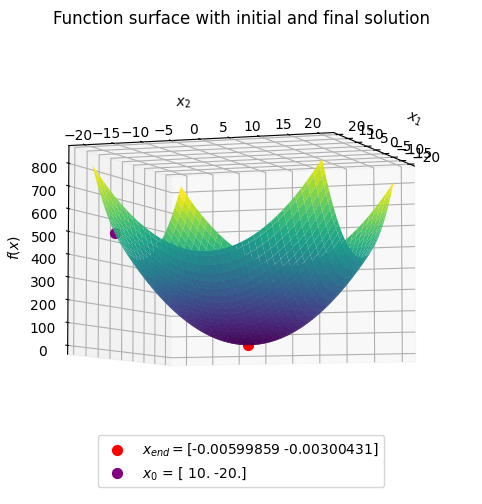

<Figure size 640x480 with 0 Axes>

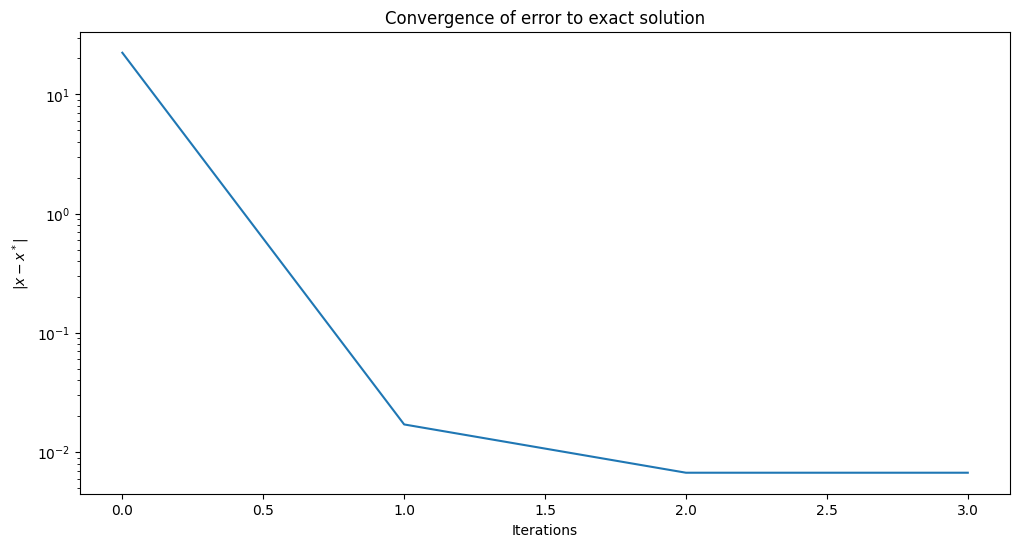

In [75]:
#Visualize function surface
x1 = x2 = np.arange(-20, 20, 0.5)
X, Y = np.meshgrid(x1, x2)
f1 = func([X, Y])
fig = plt.figure(1, figsize=(12, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, f1, cmap='viridis')
ax.scatter(x_gd[0], x_gd[1], sol, color='red', s=50, marker ="o", label = "$x_{end} = $" + str(x_gd))
ax.scatter(x1_desc[0], x2_desc[0], f_desc[0], color='purple', s=50, marker="o", label="$x_0$ = " + str(x_vec_gd[0]))
ax.view_init(-5, 20)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x)$")
ax.dist = 11
ax.legend(loc ="lower center")
ax.set_title("Function surface with initial and final solution")
plt.show()

#Error convergence
plt.figure(2)
plt.figure(figsize=(12, 6))
plt.semilogy(iteration, error_vec_gd)
plt.xlabel("Iterations")
plt.ylabel("$|x - x^*|$")
plt.title("Convergence of error to exact solution")
plt.show()

**Newtons Method**

<ipython-input-76-a74b20e69560>:14: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


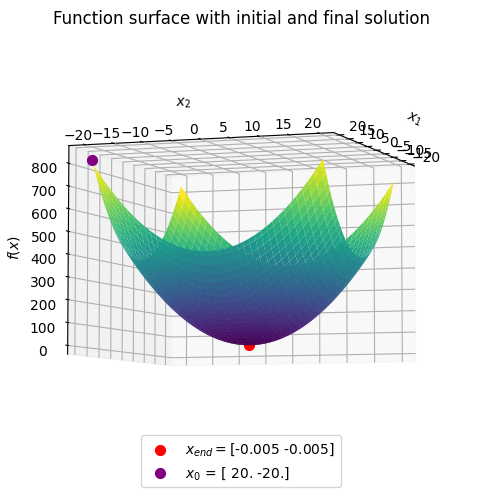

<Figure size 640x480 with 0 Axes>

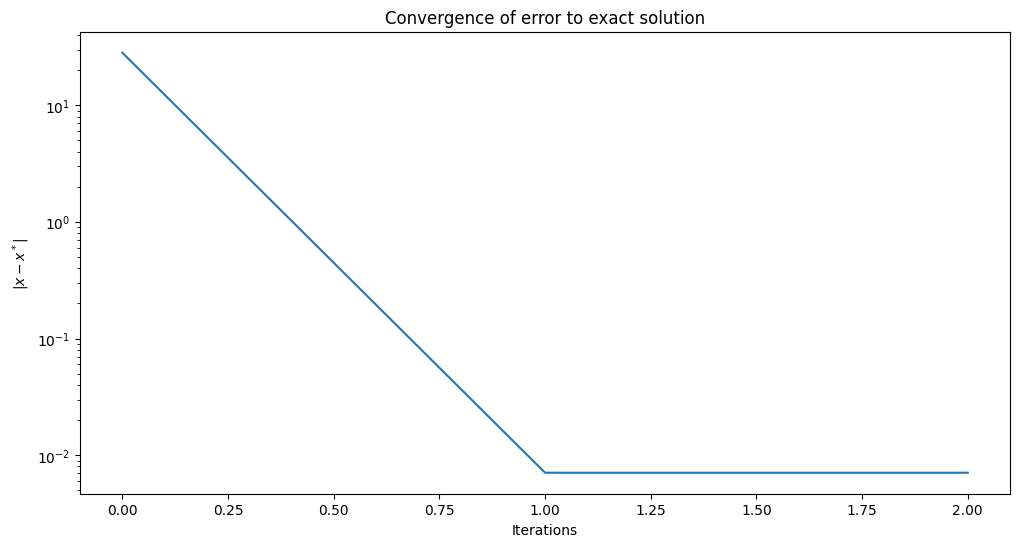

In [76]:
#Visualize function surface
x1 = x2 = np.arange(-20, 20, 0.5)
X, Y = np.meshgrid(x1, x2)
f1 = func([X, Y])
fig = plt.figure(1, figsize=(12, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, f1, cmap='viridis')
ax.scatter(x_n[0], x_n[1], sol, color='red', s=50, marker ="o", label = "$x_{end} = $" + str(x_n))
ax.scatter(x1_n[0], x2_n[0], f_n[0], color='purple', s=50, marker="o", label="$x_0$ = " + str(x_vec_n[0]))
ax.view_init(-5, 20)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x)$")
ax.dist = 11
ax.legend(loc ="lower center")
ax.set_title("Function surface with initial and final solution")
plt.show()

#Error convergence
plt.figure(2)
plt.figure(figsize=(12, 6))
plt.semilogy(iteration_n, error_vec_n)
plt.xlabel("Iterations")
plt.ylabel("$|x - x^*|$")
plt.title("Convergence of error to exact solution")
plt.show()

# **Discussion**

As seen in the figures in the result section the gradient descent method converges to the exact solution, in this case the point $x^*=[0, 0]$. The gradient descent method is great for local minimums but if the objective function would be more complex it cannot be a guaranteed global minimum, but just a critical point.

The newton method converges to the same point as the gradient descent method but it does this faster. This is probably due to the higher order calculations including the hessian in the newton method. The hessian needs to be able to be calculated in order for this method to work. If it does not then further approximations for this is needed which adds complexity.